Эта программа предназначена для прогнозирования курса валюты (в данном случае, предположительно, курса **EUR/USD**) с использованием методов машинного обучения, а именно - нейронных сетей **LSTM** (**Long Short-Term Memory**). Она осуществляет следующие действия:

1. **Загрузка и Предварительная Обработка Данных:**
     1. Загружает временной ряд курса валюты из файла **CSV**. (с сайта:**www.finance.yahoo.com**/)
     2. Преобразует даты в формат временного индекса и выбирает данные по цене закрытия ('**Close**') для анализа.
2. **Нормализация данных:**
     1. Использует **MinMaxScaler** для масштабирования цен закрытия в диапазон от **0** до **1**, что является обычной практикой при работе с нейронными сетями.
3. **Создание Временных Окон:**
     1. Преобразует данные в формат, подходящий для обучения **LSTM**, создавая "окна" фиксированного размера (здесь используется **look_back = 60**). Каждое окно содержит последовательные наблюдения, которые используются для предсказания следующего значения в ряду.
4. **Разделение данных на Обучающую и Тестовую выборки:**
     1. Данные разделяются на обучающую (**80%**) и тестовую (**20%**) выборки для обучения и валидации модели соответственно.
5. **Построение и Обучение Модели LSTM:**
     1. Создает модель **LSTM**, которая подходит для прогнозирования временных рядов из-за ее способности запоминать долгосрочные зависимости.
     2. Обучает эту модель на обучающей выборке.
6. **Оценка Производительности Модели:**
     1. Предсказывает значения на обучающей и тестовой выборках.
     2. Рассчитывает метрики ошибок (**MAE**, **MSE**, **RMSE**) для оценки точности модели.
7. **Перевод Ошибок в Проценты:**
     1. Вычисляет процентные значения ошибок относительно диапазона цен закрытия.
8. **Визуализация Результатов:**
     1. Отображает фактические и предсказанные значения на графике для наглядного сравнения.


Epoch 1/100
90/90 [==============================] - 4s 11ms/step - loss: 0.0136
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0028
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 0.0027
Epoch 4/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0022
Epoch 5/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 6/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0017
Epoch 7/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 8/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0016
Epoch 9/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0013
Epoch 10/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0012
Epoch 11/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 12/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0011
Epoch 13/100
90/90 [==============

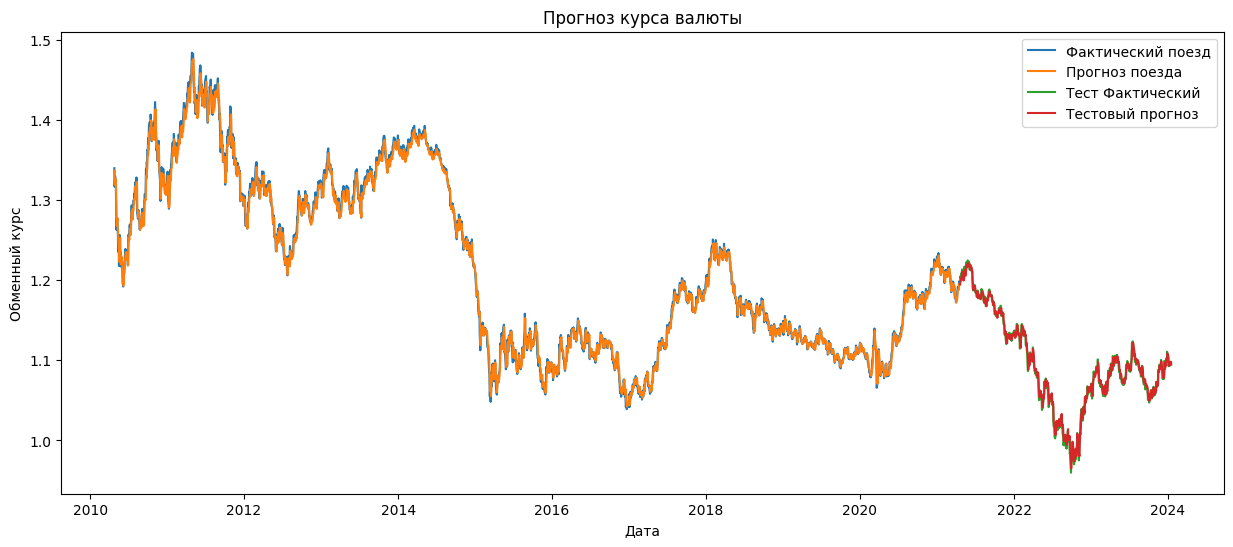

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Загрузка данных
file_path = '/content/EURUSD=X.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']].dropna()

# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# Функция для создания временных окон
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Создание временных окон
look_back = 60
X, y = create_dataset(scaled_data, look_back)

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Изменение формы данных для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1)

# Предсказания модели
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Обратное преобразование предсказаний
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Расчет метрик для оценки производительности модели
train_mae = mean_absolute_error(scaler.inverse_transform([y_train])[0], train_predict[:,0])
test_mae = mean_absolute_error(scaler.inverse_transform([y_test])[0], test_predict[:,0])
train_mse = mean_squared_error(scaler.inverse_transform([y_train])[0], train_predict[:,0])
test_mse = mean_squared_error(scaler.inverse_transform([y_test])[0], test_predict[:,0])
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f"Поезд МАЭ: {train_mae}, Тест МАЭ: {test_mae}")
print(f"Обучить MSE: {train_mse}, Тест MSE: {test_mse}")
print(f"Обучить RMSE: {train_rmse}, Тест RMSE: {test_rmse}")

# Предположим, что max_price и min_price - это максимальное и минимальное значения цен закрытия в вашем наборе данных
max_price = data['Close'].max()
min_price = data['Close'].min()
price_range = max_price - min_price

# Перевод ошибок в проценты от диапазона цен
train_error_percent = (train_rmse / price_range) * 100
test_error_percent = (test_rmse / price_range) * 100

print(f"Процент ошибок поезда: {train_error_percent:.2f}%")
print(f"Процент ошибок теста: {test_error_percent:.2f}%")

# Визуализация результатов
plt.figure(figsize=(15,6))
plt.plot(data.index[look_back:train_size+look_back], scaler.inverse_transform([y_train])[0], label='Фактический поезд')
plt.plot(data.index[look_back:train_size+look_back], train_predict[:,0], label='Прогноз поезда')
plt.plot(data.index[train_size+look_back:-1], scaler.inverse_transform([y_test])[0], label='Тест Фактический')
plt.plot(data.index[train_size+look_back:-1], test_predict[:,0], label='Тестовый прогноз')
plt.title('Прогноз курса валюты')
plt.xlabel('Дата')
plt.ylabel('Обменный курс')
plt.legend()
plt.show()


**Использование Программы:**

Эта программа может использоваться для прогнозирования будущих значений курса валюты, что полезно в финансовом анализе и торговле. Например, трейдеры могут использовать такие прогнозы для принятия решений о покупке или продаже валюты. Однако важно помнить, что, несмотря на высокую точность модели на исторических данных, прогнозы на будущее всегда сопряжены с неопределенностью, особенно на волатильных рынках, как финансовый.

Эта модель может быть особенно полезна в качестве части комплексной торговой системы или в качестве одного из инструментов анализа рынка.